In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [3]:
import os
import zipfile
import shutil

import numpy as np 
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D , MaxPooling2D , GlobalAveragePooling2D , Dense , BatchNormalization , Dropout

2026-02-18 14:02:53.298129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771423373.488692      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771423373.549740      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771423374.050782      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771423374.050825      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771423374.050828      55 computation_placer.cc:177] computation placer alr

In [4]:
os.makedirs('/kaggle/working/dogs-vs-cats',  exist_ok=True)

**Unzipping Train**

In [5]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/dogs-vs-cats')

In [6]:
os.listdir('/kaggle/working/dogs-vs-cats/train')[:5]

['cat.5202.jpg',
 'dog.3385.jpg',
 'dog.7567.jpg',
 'dog.1379.jpg',
 'cat.3163.jpg']

In [7]:
BASE_DIR = '/kaggle/working/dogs-vs-cats/train'
DATA_DIR = '/kaggle/working/dogs-vs-cats/train'

In [8]:
os.makedirs(BASE_DIR + '/cats', exist_ok=True)
os.makedirs(BASE_DIR + '/dogs', exist_ok=True)

In [9]:
for file in os.listdir(BASE_DIR):
    path = os.path.join(BASE_DIR, file)

    if os.path.isdir(path):
        continue

    if file.startswith('cat'):
        shutil.move(path, BASE_DIR + '/cats/' + file)
    elif file.startswith('dog'):
        shutil.move(path, BASE_DIR + '/dogs/' + file)

In [10]:
os.listdir('/kaggle/working/dogs-vs-cats/train')

['cats', 'dogs']

**Unizipping test**

In [11]:
os.makedirs('/kaggle/working/dogs-vs-cats/test', exist_ok=True)

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/dogs-vs-cats/test')

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=(256, 256),
    batch_size=64,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=(256, 256),
    batch_size=32,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=42
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


I0000 00:00:1771423400.206025      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771423400.212394      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
# Keras preprocessing layers 
# Resizing and Rescaling 
IMG_SIZE = 160

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE , IMG_SIZE),
    layers.Rescaling(1./255)
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomWidth(0.1),
    tf.keras.layers.RandomHeight(0.1),
])

# Making the preprocessing layers part of our model
model = Sequential([
    tf.keras.Input(shape=(256,256,3)),
    resize_and_rescale,
    data_augmentation,

    Conv2D(32, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(256, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

In [14]:
# Lowering the learning rate 
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy',
             metrics=['accuracy'])
# Using Early Stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2
    )
]


In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, None, None,     │         1,024 │
│ (BatchNormalization)            │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,361 (1.61 MB)

 Trainable params: 422,401 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [16]:
import time

start = time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

end = time.time()

print(f"Training time: {end - start:.2f} seconds")


Epoch 1/20


I0000 00:00:1771423410.118699     131 cuda_dnn.cc:529] Loaded cuDNN version 91002


313/313 ━━━━━━━━━━━━━━━━━━━━ 193s 588ms/step - accuracy: 0.6068 - loss: 0.6761 - val_accuracy: 0.4926 - val_loss: 0.9148 - learning_rate: 1.0000e-04
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 107s 344ms/step - accuracy: 0.6868 - loss: 0.5931 - val_accuracy: 0.6856 - val_loss: 0.5885 - learning_rate: 1.0000e-04
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 277ms/step - accuracy: 0.7158 - loss: 0.5577 - val_accuracy: 0.7144 - val_loss: 0.5498 - learning_rate: 1.0000e-04
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 225ms/step - accuracy: 0.7371 - loss: 0.5263 - val_accuracy: 0.7546 - val_loss: 0.5097 - learning_rate: 1.0000e-04
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 210ms/step - accuracy: 0.7555 - loss: 0.5023 - val_accuracy: 0.7798 - val_loss: 0.4641 - learning_rate: 1.0000e-04
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 190ms/step - accuracy: 0.7692 - loss: 0.4784 - val_accuracy: 0.7518 - val_loss: 0.4923 - learning_rate: 1.0000e-04
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step 

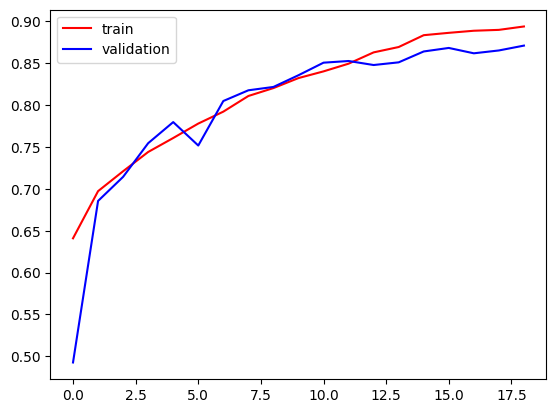

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color='red' , label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

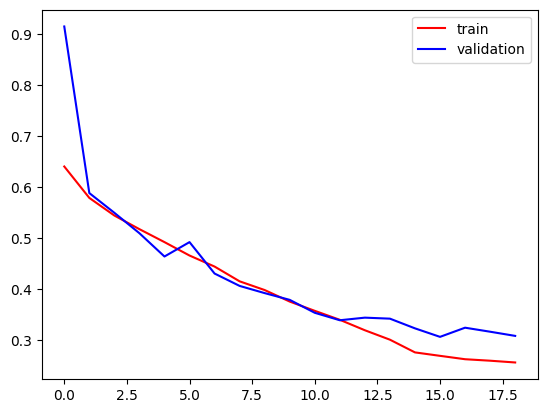

In [18]:
plt.plot(history.history['loss'], color='red' , label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

# Prediction on test data

In [19]:
TEST_DIR = "/kaggle/working/dogs-vs-cats/test/test1"
IMG_SIZE = 160     # same as training
BATCH_SIZE = 32


In [20]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,      
    labels=None
)


Found 12500 files.


In [21]:
image_files = sorted(
    [f for f in os.listdir(TEST_DIR) if f.endswith(".jpg")],
    key=lambda x: int(x.split(".")[0])
)

image_ids = [int(f.split(".")[0]) for f in image_files]


In [22]:
predictions = model.predict(test_ds)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)


391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step


In [23]:
predictions = model.predict(test_ds)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)


391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


In [24]:
print(image_ids[:5])
print(predicted_labels[:5])
print(len(image_ids), len(predicted_labels))


[1, 2, 3, 4, 5]
[1 0 0 1 0]
12500 12500


In [25]:

label_map = {0: "cat", 1: "dog"}


In [1]:
# show first N images
N = 20

plt.figure(figsize=(15, 5))

for i in range(N):
    img_path = os.path.join(TEST_DIR, image_files[i])
    img = plt.imread(img_path)

    plt.subplot(1, N, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"ID: {image_ids[i]}\nPred: {label_map[predicted_labels[i]]}")

plt.show()

NameError: name 'plt' is not defined

In [27]:
print(predictions[:5].reshape(-1))


[0.67426    0.0422957  0.07647368 0.7641858  0.40174162]
